In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Verileri yükle
processed_dir = '../data/processed/'
X_train = pd.read_csv(processed_dir + 'X_train.csv')
X_val = pd.read_csv(processed_dir + 'X_val.csv')
y_train = pd.read_csv(processed_dir + 'y_train.csv').squeeze() # .squeeze() ile Seriye dönüştür
y_val = pd.read_csv(processed_dir + 'y_val.csv').squeeze()
weights_train = pd.read_csv(processed_dir + 'weights_train.csv').squeeze()
weights_val = pd.read_csv(processed_dir + 'weights_val.csv').squeeze()

print("Veriler başarıyla yüklendi.")

Veriler başarıyla yüklendi.


In [3]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Modeli oluşturalım
# Temel parametrelerle başlıyoruz, random_state tekrarlanabilirlik için önemli
model = xgb.XGBClassifier(objective='binary:logistic',
                          eval_metric='logloss',
                          random_state=42)

# Modeli EĞİTME ANI!
# Fiziksel ağırlıkları `sample_weight` parametresi ile modele veriyoruz.
print("Model eğitimi başlıyor...")
model.fit(X_train, y_train, sample_weight=weights_train)
print("Model eğitimi tamamlandı.")

Model eğitimi başlıyor...
Model eğitimi tamamlandı.


In [4]:
# Sınıf tahminleri (0 veya 1)
y_pred = model.predict(X_val)

# Sınıf olasılıkları (AUC skoru için pozitif sınıfın olasılığı gerekir)
y_pred_proba = model.predict_proba(X_val)[:, 1]

In [5]:
accuracy = accuracy_score(y_val, y_pred)
print(f"Modelin Doğruluk Oranı: {accuracy:.4f}")

Modelin Doğruluk Oranı: 0.6832


In [6]:
# AUC skorunu ağırlıkları kullanarak hesaplamak, fiziksel olarak daha doğru bir sonuç verir.
roc_auc = roc_auc_score(y_val, y_pred_proba, sample_weight=weights_val)
print(f"Ağırlıklı ROC AUC Skoru: {roc_auc:.4f}")

Ağırlıklı ROC AUC Skoru: 0.9303


In [7]:
print("\nSınıflandırma Raporu:")
print(classification_report(y_val, y_pred, target_names=['Arka Plan (0)', 'Sinyal (1)']))


Sınıflandırma Raporu:
               precision    recall  f1-score   support

Arka Plan (0)       0.67      1.00      0.81     32867
   Sinyal (1)       0.98      0.08      0.14     17133

     accuracy                           0.68     50000
    macro avg       0.83      0.54      0.47     50000
 weighted avg       0.78      0.68      0.58     50000



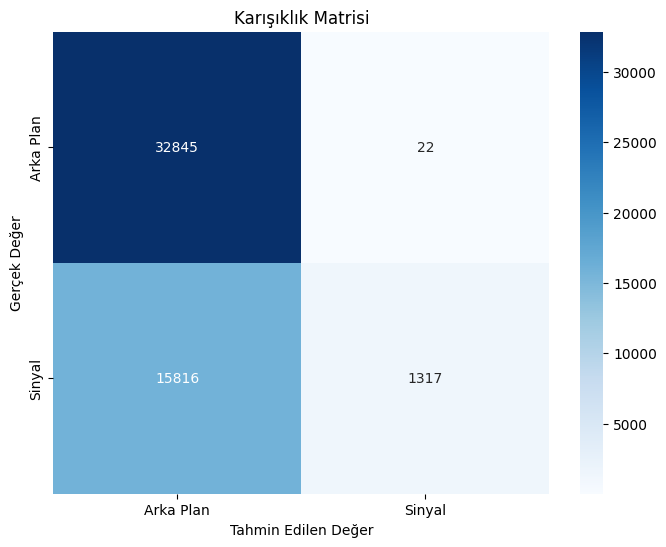

In [8]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Arka Plan', 'Sinyal'], 
            yticklabels=['Arka Plan', 'Sinyal'])
plt.title('Karışıklık Matrisi')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen Değer')
plt.show()

scale_pos_weight oranı: 1.92

Dengelenmiş model eğitimi başlıyor...


C:\Users\idris\Documents\cern-particle-classifier\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:50:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Eğitim tamamlandı.

--- Dengelenmiş Modelin Performansı ---
Eski Model Sinyal Tahminleri (Doğru Pozitif): 1317
Yeni Model Sinyal Tahminleri (Doğru Pozitif): 1873

Yeni Sınıflandırma Raporu:
               precision    recall  f1-score   support

Arka Plan (0)       0.68      1.00      0.81     32867
   Sinyal (1)       0.97      0.11      0.20     17133

     accuracy                           0.69     50000
    macro avg       0.83      0.55      0.50     50000
 weighted avg       0.78      0.69      0.60     50000



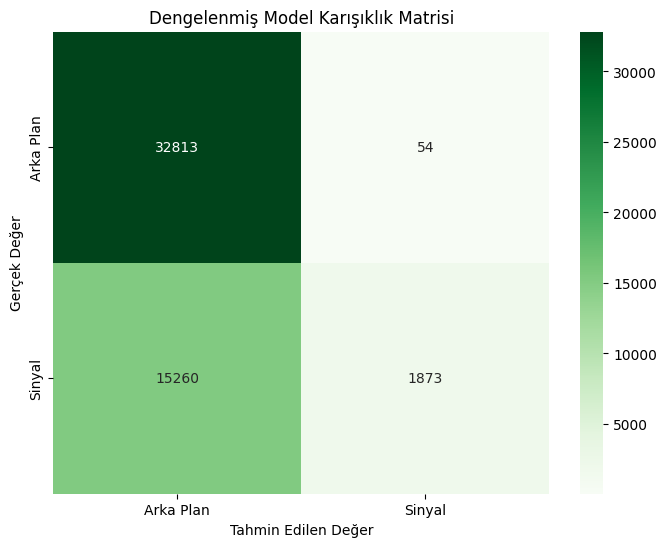

In [9]:
# 1. scale_pos_weight oranını hesaplayalım
# Eğitim setindeki etiket sayılarını kullanıyoruz.
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"scale_pos_weight oranı: {ratio:.2f}")

# 2. Modeli bu yeni parametre ile tekrar oluşturalım
model_balanced = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=ratio,  # <-- SİHİRLİ PARAMETRE
    random_state=42
)

# 3. Dengelenmiş modeli eğitelim
print("\nDengelenmiş model eğitimi başlıyor...")
model_balanced.fit(X_train, y_train, sample_weight=weights_train)
print("Eğitim tamamlandı.")

# 4. Yeni modelin performansını değerlendirelim
print("\n--- Dengelenmiş Modelin Performansı ---")
y_pred_balanced = model_balanced.predict(X_val)
cm_balanced = confusion_matrix(y_val, y_pred_balanced)

print(f"Eski Model Sinyal Tahminleri (Doğru Pozitif): {cm[1, 1]}")
print(f"Yeni Model Sinyal Tahminleri (Doğru Pozitif): {cm_balanced[1, 1]}")
print("\nYeni Sınıflandırma Raporu:")
print(classification_report(y_val, y_pred_balanced, target_names=['Arka Plan (0)', 'Sinyal (1)']))

# Yeni karışıklık matrisini çizdirelim
plt.figure(figsize=(8, 6))
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Arka Plan', 'Sinyal'], 
            yticklabels=['Arka Plan', 'Sinyal'])
plt.title('Dengelenmiş Model Karışıklık Matrisi')
plt.ylabel('Gerçek Değer')
plt.xlabel('Tahmin Edilen Değer')
plt.show()

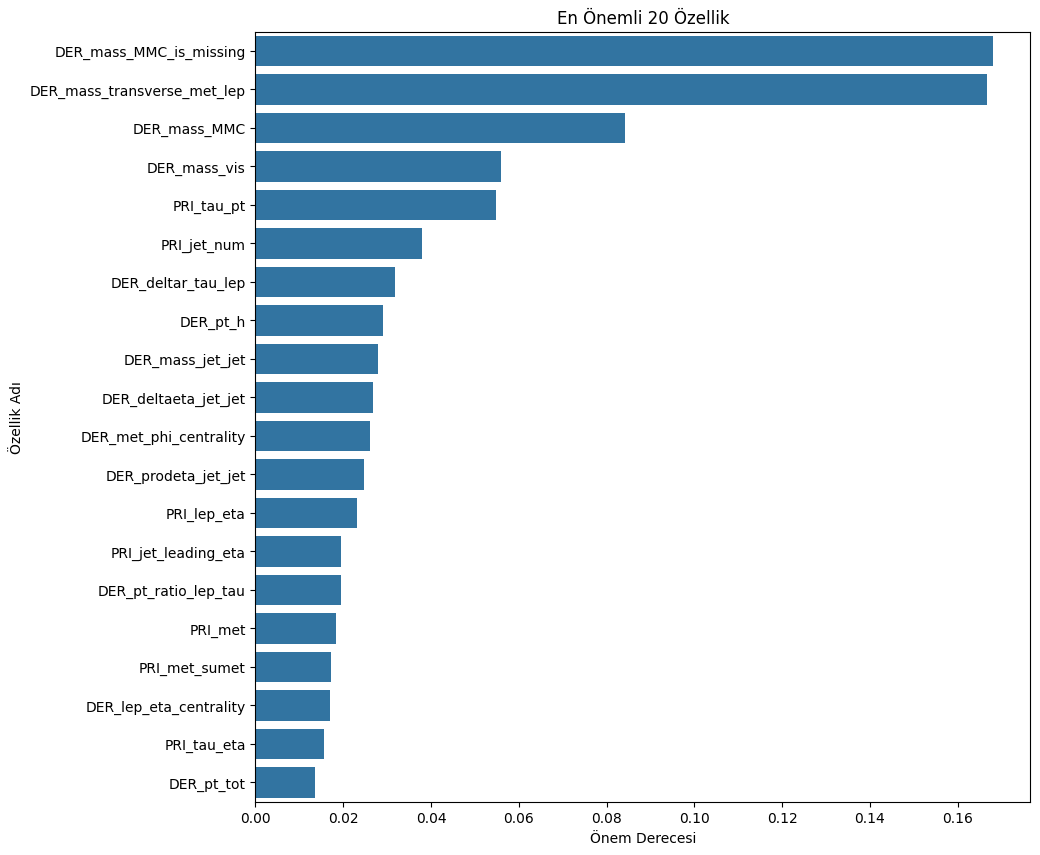

In [10]:
# Özellik önemliliğini alalım ve bir DataFrame'e dönüştürelim
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_balanced.feature_importances_
}).sort_values('importance', ascending=False)

# En önemli 20 özelliği görselleştirelim
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('En Önemli 20 Özellik')
plt.xlabel('Önem Derecesi')
plt.ylabel('Özellik Adı')
plt.show()